In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-04 11:30:32.614833: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-04 11:30:33.412003: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-04 11:30:33.460189: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-04 11:30:33.460236: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-04 11:30:33.464727: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-04 11:30:33.464790: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-04 11:30:33.466792: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

iawe_gen_GASF_60m_300S0X_R82_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['air conditioner', 'computer', 'fridge', 'television']
{0: 4.76595744680851, 1: 0.8265682656826568, 2: 0.43118383060635224, 3: 3.8290598290598292}
 
Tests 
air conditioner test: 23 train: 94
computer test: 136 train: 542
fridge test: 260 train: 1039
television test: 30 train: 117


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/CNN/iawe/TL/iawe_82_refit, eco, redd, ukdale_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data iawe training on model refit seed 82
reading data, printing stats: 
['air conditioner', 'computer', 'fridge', 'television']
{0: 4.76595744680851, 1: 0.8265682656826568, 2: 0.43118383060635224, 3: 3.8290598290598292}
 
Tests 
air conditioner test: 23 train: 94
computer test: 136 train: 542
fridge test: 260 train: 1039
television test: 30 train: 117
loading model
compling TL model..


2022-02-04 11:30:33.986195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-04 11:30:33.986525: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-04 11:30:33.986576: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-04 11:30:34.350236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-04 11:30:34.350272: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-04 11:30:34.350279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-04 11:30:34.350824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-04 11:30:34.961886: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-04 11:30:34.980604: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/50


2022-02-04 11:30:35.466476: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-04 11:30:35.924078: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-04 11:30:36.380862: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-04 11:30:36.789160: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


224/224 - 5s - loss: 0.8586 - accuracy: 0.8008
Epoch 2/50
224/224 - 4s - loss: 0.3740 - accuracy: 0.8599
Epoch 3/50
224/224 - 4s - loss: 0.2264 - accuracy: 0.9001
Epoch 4/50
224/224 - 4s - loss: 0.1787 - accuracy: 0.9035
Epoch 5/50
224/224 - 4s - loss: 0.1364 - accuracy: 0.9297
Epoch 6/50
224/224 - 4s - loss: 0.1406 - accuracy: 0.9241
Epoch 7/50
224/224 - 4s - loss: 0.1056 - accuracy: 0.9442
Epoch 8/50
224/224 - 4s - loss: 0.0963 - accuracy: 0.9570
Epoch 9/50
224/224 - 4s - loss: 0.0715 - accuracy: 0.9637
Epoch 10/50
224/224 - 4s - loss: 0.0774 - accuracy: 0.9643
Epoch 11/50
224/224 - 4s - loss: 0.2027 - accuracy: 0.9308
Epoch 12/50
224/224 - 4s - loss: 0.2217 - accuracy: 0.9336
Epoch 13/50
224/224 - 4s - loss: 0.0584 - accuracy: 0.9760
Epoch 14/50
224/224 - 4s - loss: 0.0349 - accuracy: 0.9782
Epoch 15/50
224/224 - 4s - loss: 0.0608 - accuracy: 0.9643
Epoch 16/50
224/224 - 4s - loss: 0.0355 - accuracy: 0.9777
Epoch 17/50
224/224 - 4s - loss: 0.0274 - accuracy: 0.9838
Epoch 18/50
224/2

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
224/224 - 4s - loss: 1.9550 - accuracy: 0.6585
Epoch 2/50
224/224 - 4s - loss: 0.5694 - accuracy: 0.7561
Epoch 3/50
224/224 - 4s - loss: 0.6003 - accuracy: 0.7059
Epoch 4/50
224/224 - 4s - loss: 0.4292 - accuracy: 0.7952
Epoch 5/50
224/224 - 4s - loss: 0.3244 - accuracy: 0.8320
Epoch 6/50
224/224 - 4s - loss: 0.4486 - accuracy: 0.8549
Epoch 7/50
224/224 - 4s - loss: 0.2558 - accuracy: 0.8823
Epoch 8/50
224/224 - 4s - loss: 0.4318 - accuracy: 0.8594
Epoch 9/50
224/224 - 4s - loss: 0.5329 - accuracy: 0.8588
Epoch 10/50
224/224 - 4s - loss: 0.3969 - accuracy: 0.8683
Epoch 11/50
224/224 - 4s - loss: 0.2014 - accuracy: 0.8990
Epoch 12/50
224/224 - 4s - loss: 0.2118 - accuracy: 0.9191
Epoch 13/50
224/224 - 4s - loss: 0.2861 - accuracy: 0.8560
Epoch 14/50
224/224 - 4s - loss: 0.3234 - accuracy: 0.8856
Epoch 15/50
224/224 - 4s - loss: 0.2191 - accuracy: 0.8934
Epoch 16/50
224/224 - 4s - loss: 0.1903 - accuracy: 0.9397
Epoch 17/50
224/224 - 4s - loss:

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
224/224 - 4s - loss: 6.1470 - accuracy: 0.2941
Epoch 2/50
224/224 - 4s - loss: 1.7349 - accuracy: 0.5530
Epoch 3/50
224/224 - 4s - loss: 0.8272 - accuracy: 0.4833
Epoch 4/50
224/224 - 4s - loss: 0.6946 - accuracy: 0.5128
Epoch 5/50
224/224 - 3s - loss: 0.6386 - accuracy: 0.6908
Epoch 6/50
224/224 - 4s - loss: 0.6035 - accuracy: 0.6110
Epoch 7/50
224/224 - 4s - loss: 0.5743 - accuracy: 0.5413
Epoch 8/50
224/224 - 3s - loss: 0.5832 - accuracy: 0.5329
Epoch 9/50
224/224 - 4s - loss: 0.5818 - accuracy: 0.5558
Epoch 10/50
224/224 - 4s - loss: 0.5345 - accuracy: 0.5547
Epoch 11/50
224/224 - 4s - loss: 0.5192 - accuracy: 0.5525
Epoch 12/50
224/224 - 4s - loss: 0.5059 - accuracy: 0.5564
Epoch 13/50
224/224 - 4s - loss: 0.4720 - accuracy: 0.5564
Epoch 14/50
224/224 - 4s - loss: 0.4693 - accuracy: 0.5647
Epoch 15/50
224/224 - 3s - loss: 0.4940 - accuracy: 0.6362
Epoch 16/50
224/224 - 4s - loss: 0.4533 - accuracy: 0.6920
Epoch 17/50
224/224 - 4s - loss:

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
224/224 - 4s - loss: 1.2456 - accuracy: 0.7533
Epoch 2/50
224/224 - 3s - loss: 0.3136 - accuracy: 0.8800
Epoch 3/50
224/224 - 3s - loss: 0.7640 - accuracy: 0.8186
Epoch 4/50
224/224 - 3s - loss: 0.2566 - accuracy: 0.8901
Epoch 5/50
224/224 - 4s - loss: 0.1435 - accuracy: 0.9353
Epoch 6/50
224/224 - 4s - loss: 0.0776 - accuracy: 0.9665
Epoch 7/50
224/224 - 4s - loss: 0.0618 - accuracy: 0.9743
Epoch 8/50
224/224 - 4s - loss: 0.0874 - accuracy: 0.9581
Epoch 9/50
224/224 - 4s - loss: 0.1706 - accuracy: 0.9336
Epoch 10/50
224/224 - 3s - loss: 0.1071 - accuracy: 0.9542
Epoch 11/50
224/224 - 4s - loss: 0.0902 - accuracy: 0.9587
Epoch 12/50
224/224 - 4s - loss: 0.0630 - accuracy: 0.9721
Epoch 13/50
224/224 - 3s - loss: 0.0378 - accuracy: 0.9799
Epoch 14/50
224/224 - 4s - loss: 0.3301 - accuracy: 0.9453
Epoch 15/50
224/224 - 4s - loss: 0.1541 - accuracy: 0.9436
Epoch 16/50
224/224 - 4s - loss: 0.0692 - accuracy: 0.9766
Epoch 17/50
224/224 - 4s - loss:

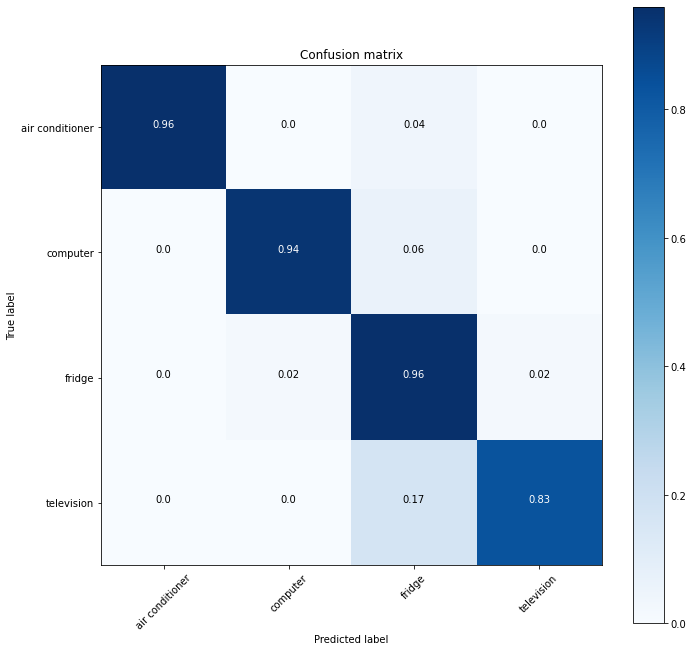

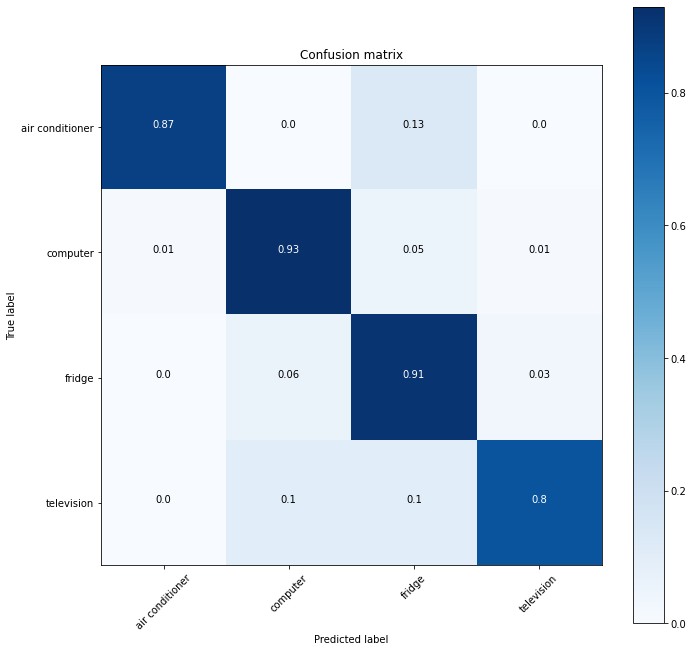

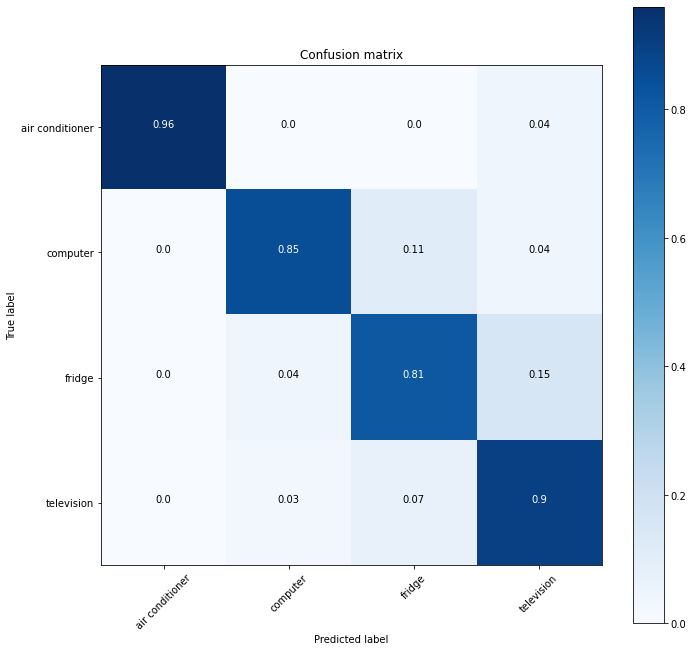

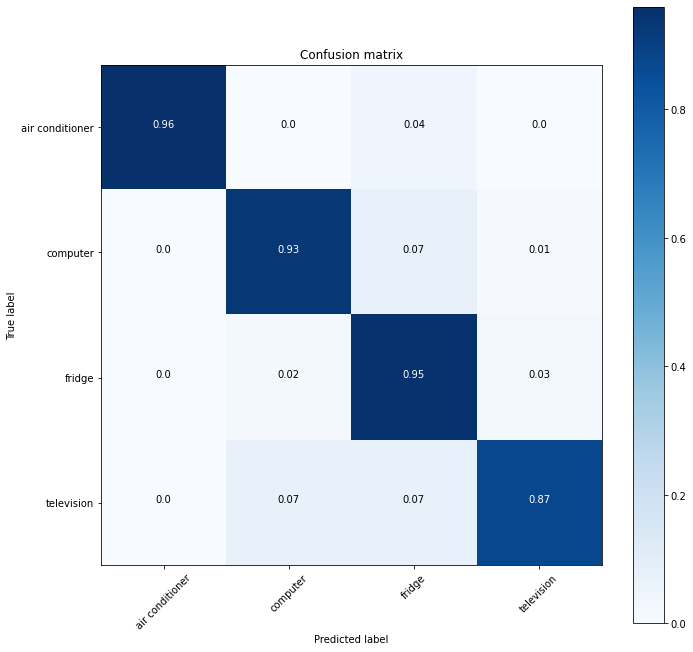

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()